<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/vqvae_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Based on 

https://arxiv.org/abs/1711.00937  
https://arxiv.org/abs/1906.00446

https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [0]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

# Create some data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=10, n_features=50,random_state=0)

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(8)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(4)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(2)(h)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = snt.Linear(4)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(8)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(self.output_dim)(h)
    return h

# Build Graph and train

In [107]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32

num_training_updates = 10000
embedding_dim = 2
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 15

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
z = encoder(x)

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_samples(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 100 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()


100 iterations
recon_error: 544.644
perplexity: 8.881

200 iterations
recon_error: 526.604
perplexity: 6.085

300 iterations
recon_error: 512.928
perplexity: 6.023

400 iterations
recon_error: 496.003
perplexity: 7.558

500 iterations
recon_error: 478.531
perplexity: 7.451

600 iterations
recon_error: 459.545
perplexity: 7.407

700 iterations
recon_error: 441.837
perplexity: 7.259

800 iterations
recon_error: 424.612
perplexity: 7.038

900 iterations
recon_error: 405.196
perplexity: 7.306

1000 iterations
recon_error: 389.118
perplexity: 7.442

1100 iterations
recon_error: 374.169
perplexity: 7.702

1200 iterations
recon_error: 359.628
perplexity: 7.800

1300 iterations
recon_error: 343.101
perplexity: 7.871

1400 iterations
recon_error: 334.720
perplexity: 7.969

1500 iterations
recon_error: 324.899
perplexity: 7.855

1600 iterations
recon_error: 312.241
perplexity: 7.869

1700 iterations
recon_error: 302.719
perplexity: 7.733

1800 iterations
recon_error: 293.923
perplexity: 7.612

1

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

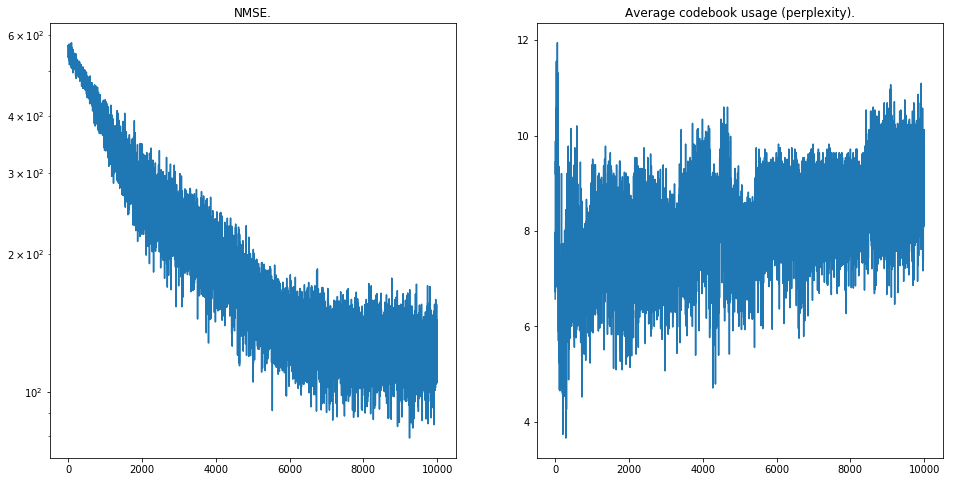

In [108]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

In [0]:
# Latent space
z_, vq_output_eval_  = sess.run([z, vq_output_eval], feed_dict={x: X})

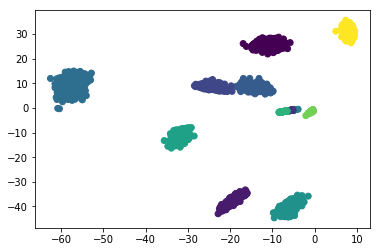

In [110]:
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'])